# Setting Environment

In [2]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Checking GPU

In [3]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

# List GPUs available
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)

# Check if GPUs are available
if gpus:
    print("GPU is available.")
else:
    print("GPU is not available.")

# Set memory growth for each GPU
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


2024-09-02 10:04:51.959940: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-02 10:04:51.976611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 10:04:51.999119: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 10:04:52.007138: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-02 10:04:52.022728: I tensorflow/core/platform/cpu_feature_guar

TensorFlow version: 2.17.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available.


I0000 00:00:1725251693.934475    7399 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725251693.973642    7399 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725251693.973874    7399 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


# Importing Modules

In [4]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
import segmentation_models as sm
from PIL import Image
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from patchify import patchify
import cv2
import numpy as np
import shutil
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

Segmentation Models: using `tf.keras` framework.


In [5]:
class_indices={'Water':"50E3C2",'Land' : "F5A623",'Road' : 'DE597F','Building' : 'D0021B','Vegetation' : "417505",'Unlabeled' : "9B9B9B"}

In [6]:
#Convert HEX to RGB array

a=int('3C', 16)  #3C with base 16. Should return 60.
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155


60


In [7]:
list_1=[Water,Land,Road,Building,Vegetation,Unlabeled]
new_list=[str(i) for i in list_1]

In [9]:
le=LabelEncoder()

In [10]:
encoder_dict=dict()
count=0
for i in class_indices.keys():
    encoder_dict[i]=count
    count+=1

In [11]:
encoder_dict

{'Water': 0,
 'Land': 1,
 'Road': 2,
 'Building': 3,
 'Vegetation': 4,
 'Unlabeled': 5}

In [14]:
new_values=to_categorical(list(encoder_dict.values()))

In [15]:
count=0
for i in encoder_dict.keys():
    encoder_dict[i]=new_values[count]
    count+=1

In [16]:
encoder_dict

{'Water': array([1., 0., 0., 0., 0., 0.]),
 'Land': array([0., 1., 0., 0., 0., 0.]),
 'Road': array([0., 0., 1., 0., 0., 0.]),
 'Building': array([0., 0., 0., 1., 0., 0.]),
 'Vegetation': array([0., 0., 0., 0., 1., 0.]),
 'Unlabeled': array([0., 0., 0., 0., 0., 1.])}

In [17]:
count=0
new_dict=dict()
for j in encoder_dict.values():
    new_dict[new_list[count]]=j
    count+=1

In [19]:
def checker_helper(s):
    s = s.strip("[]")
    s_list = s.split()
    int_list = list(map(int, s_list))
    return np.array(int_list)

In [31]:
img_path='/home/jackson-divakar/Documents/Data/Training Data/Train_Masks/Train/image_part_001 (7)_patch_0_0.png'

In [36]:
msk_img_array=np.array(load_img(img_path))

In [52]:
print(np.unique(msk_img_array))

[ 16  41  58  60 110 132 152 193 221 228 246 254]


In [51]:
new_dict

{'[226 169  41]': array([1., 0., 0., 0., 0., 0.]),
 '[132  41 246]': array([0., 1., 0., 0., 0., 0.]),
 '[110 193 228]': array([0., 0., 1., 0., 0., 0.]),
 '[ 60  16 152]': array([0., 0., 0., 1., 0., 0.]),
 '[254 221  58]': array([0., 0., 0., 0., 1., 0.]),
 '[155 155 155]': array([0., 0., 0., 0., 0., 1.])}

# Generator

In [57]:

def color_to_one(mask, num_class=6):
    fake = np.zeros((mask.shape[0], mask.shape[1], mask.shape[2], num_class))
    for i, j in new_dict.items():
        condition = np.all(mask == checker_helper(i), axis=-1)
        fake[condition] = j
    return fake
BATCH_SIZE = 3
seed = 3
IMG_SIZE=(224,224)
def train_generator(img_path, mask_path):

    img_gen_dict = dict(
    horizontal_flip=True,         # Flip images horizontally
    vertical_flip=True,           # Flip images vertically
    rotation_range=15,            # Rotate images by up to 15 degrees
    width_shift_range=0.1,        # Shift images horizontally by up to 10% of the width
    height_shift_range=0.1,       # Shift images vertically by up to 10% of the height
    zoom_range=0.2,               # Zoom in/out by up to 20%
    shear_range=0.1,              # Shear the image by up to 10%
    brightness_range=(0.8, 1.2),  # Adjust brightness between 80% and 120%
    fill_mode='reflect')
    
    
    mask_gen_dict = dict(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=15,  # Ensure this matches the image generator
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='reflect'  # No brightness adjustment
    )


    
    train_image_gen = ImageDataGenerator(**img_gen_dict)
    train_mask_gen = ImageDataGenerator(**mask_gen_dict)
    
    image_generator = train_image_gen.flow_from_directory(
        img_path, 
        class_mode=None, 
        batch_size=BATCH_SIZE,
        target_size=IMG_SIZE,
        seed=seed
    )
    
    mask_generator = train_mask_gen.flow_from_directory(
        mask_path, 
        class_mode=None,  # Ensure class_mode is None since masks are not categorical here
        batch_size=BATCH_SIZE,
        target_size=IMG_SIZE,
        seed=seed
    )
    
    train_gen = zip(image_generator, mask_generator)
    
    for img, mask in train_gen:
        # Print or inspect the mask shape and content
        img=img/255.0
        # Assuming mask is the correct data type, continue with your processing
        mask = mask.astype(int)  # Ensure mask is an integer type
        mask = color_to_one(mask, 6)
        yield img, mask




In [58]:
train_img_path='Data/Training Data/Train_Images'
train_msk_path='Data/Training Data/Train_Masks'
val_img_path='Data/Val Data/Val_Images'
val_msk_path='Data/Val Data/Val _Masks'

In [59]:
train_gen=train_generator(train_img_path,train_msk_path)
val_gen=train_generator(val_img_path,val_msk_path)

In [60]:
x,y=train_gen.__next__()

Found 1483 images belonging to 1 classes.
Found 1483 images belonging to 1 classes.


In [63]:
x,y=val_gen.__next__()

Found 164 images belonging to 1 classes.
Found 164 images belonging to 1 classes.


# Losses

In [69]:
weights=[1/6]*6
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [1]:


def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)


In [71]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=224, IMG_WIDTH=224, IMG_CHANNELS=1):
    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [72]:
metrics=['accuracy', jacard_coef]

In [73]:
def get_model():
    return multi_unet_model(n_classes=6, IMG_HEIGHT=224, IMG_WIDTH=224, IMG_CHANNELS=3)

# Model Loading

In [75]:
model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.summary()

I0000 00:00:1725253051.582960    7399 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725253051.583301    7399 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725253051.583529    7399 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725253051.672730    7399 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 224, 224,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 112, 112,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 56, 56,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 28, 28,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,190 (7.41 MB)

 Trainable params: 1,941,190 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

# Callbacks

In [91]:


# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_jacard_coef',     # The metric to be monitored, typically validation loss
    factor=0.5,             # Factor by which the learning rate will be reduced
    patience=5,             # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,            # Lower bound on the learning rate
    cooldown=0,             # Number of epochs to wait before resuming normal operation after lr has been reduced
    verbose=1               # Set to 1 to display a message when the learning rate is reduced
)

In [88]:
model_check=ModelCheckpoint('Path to save model',monitor='val_jacard_coef',save_best_only=True,mode='max')

In [89]:
steps_per_epoch=1483//BATCH_SIZE

In [90]:
validation_steps=164//BATCH_SIZE

# Model Fitting

In [96]:
model.fit(train_gen,batch_size=BATCH_SIZE,epochs=50,validation_data=val_gen,callbacks=[model_check,reduce_lr],steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Epoch 1/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.6837 - jacard_coef: 0.4447 - loss: 0.9732 - val_accuracy: 0.6163 - val_jacard_coef: 0.3708 - val_loss: 0.9755 - learning_rate: 1.9531e-06
Epoch 2/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.6957 - jacard_coef: 0.4541 - loss: 0.9711 - val_accuracy: 0.6550 - val_jacard_coef: 0.4107 - val_loss: 0.9740 - learning_rate: 1.9531e-06
Epoch 3/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.6909 - jacard_coef: 0.4533 - loss: 0.9733 - val_accuracy: 0.6382 - val_jacard_coef: 0.3917 - val_loss: 0.9731 - learning_rate: 1.9531e-06
Epoch 4/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.6962 - jacard_coef: 0.4627 - loss: 0.9722 - val_accuracy: 0.6187 - val_jacard_coef: 0.3731 - val_loss: 0.9796 - learning_rate: 1.9531e-06
Epoch 5/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.6856 - jacard_coef: 0.4448 - loss: 0.9722 - val_accuracy: 0.6123 - val_jacard_coef: 0.3763 - val_loss: 0.979

KeyboardInterrupt: 

# Segment Prediction

In [107]:
path='path to predict image mask'

In [108]:
from PIL import Image

In [109]:
image=Image.open(path)

In [110]:
image = image.convert("RGB")

In [111]:
image=image.resize((224,224))

In [112]:
image=np.array(image)

In [114]:
predicted=model.predict((np.expand_dims(image,axis=0)/255.0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [115]:
argmaxed=np.argmax(predicted,axis=-1)

In [116]:
new_dict_2=dict()
count=0
for i, j in new_dict.items():
    new_dict_2[count]=checker_helper(i)
    count+=1

In [117]:
argmaxed=np.squeeze(argmaxed,axis=0)

In [118]:
rgb_image = np.zeros((224, 224, 3), dtype=np.uint8)

# Map each pixel in the model output to its corresponding RGB value
for key, color in new_dict_2.items():
    rgb_image[argmaxed == key] = color

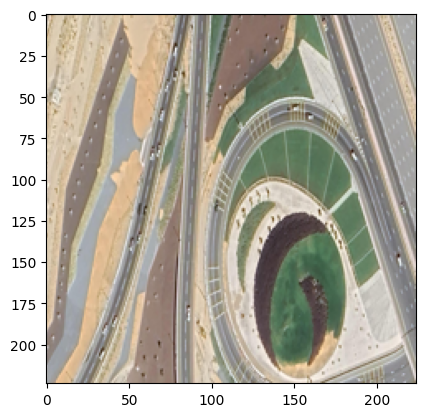

In [119]:
plt.imshow(image)

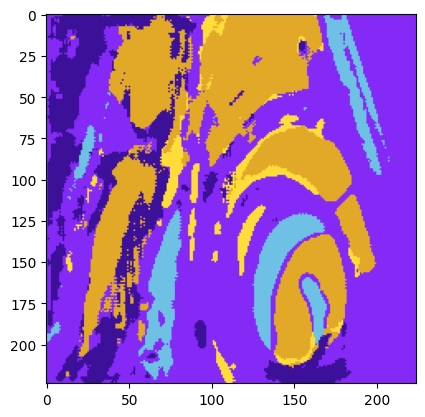

In [120]:
plt.imshow(rgb_image)